<a href="https://colab.research.google.com/github/prasys/qrc-mlteamprojects/blob/kyle/Pipeline/LoadAllModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10K4Qe2NFZhqy0aWYaQz5050K-ycpUTco' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10K4Qe2NFZhqy0aWYaQz5050K-ycpUTco" -O creditcard.csv && rm -rf /tmp/cookies.txt

--2023-12-02 12:52:20--  https://docs.google.com/uc?export=download&confirm=t&id=10K4Qe2NFZhqy0aWYaQz5050K-ycpUTco
Resolving docs.google.com (docs.google.com)... 142.250.101.102, 142.250.101.101, 142.250.101.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4kfn000qte72s80io05m7gav5jmj6njl/1701521475000/17337244698426673086/*/10K4Qe2NFZhqy0aWYaQz5050K-ycpUTco?e=download&uuid=199f0409-c83d-46c8-b9f8-d6e0a060128e [following]
--2023-12-02 12:52:20--  https://doc-04-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4kfn000qte72s80io05m7gav5jmj6njl/1701521475000/17337244698426673086/*/10K4Qe2NFZhqy0aWYaQz5050K-ycpUTco?e=download&uuid=199f0409-c83d-46c8-b9f8-d6e0a060128e
Resolving doc-04-4c-docs.googleusercontent.com (doc-04-4c-docs.googleusercontent.com)... 74.125.137.1

In [ ]:
!pip install flaml pivotpal

# 1. Import Packages

In [ ]:
# Basic Data Handling and Visualization
import pivotpal as pp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Machine Learning Models and Utilities
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from joblib import dump
import os

# Metrics for Model Evaluation
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    precision_recall_curve, confusion_matrix
)

# Handling Imbalanced Datasets
from imblearn.over_sampling import SMOTE

# 2. Get saved models from Github

In [ ]:
import os
import requests

# Directory for saving models
models_dir = '/content/models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Base URL for raw content in the GitHub repository
base_url = "https://raw.githubusercontent.com/prasys/qrc-mlteamprojects/main/models/"

# List of model filenames
model_filenames = [
    "Smote_AutoML_XGBoost.joblib",
    "AutoML_LightGBM.joblib",
    "AutoML_XGBoost.joblib",
    "Manual_DecisionTree.joblib",
    "Smote_AutoML_LightGBM.joblib",
    "Smote_Manual_DecisionTree.joblib",
    "Smote_Standard_LogisticRegression.joblib",
    "Standard_LogisticRegression.joblib",
    "autoML.joblib"
]

# Download each model
for filename in model_filenames:
    url = base_url + filename
    response = requests.get(url)
    if response.status_code == 200:
        with open(os.path.join(models_dir, filename), 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {filename}")


Downloaded Smote_AutoML_XGBoost.joblib
Downloaded AutoML_LightGBM.joblib
Downloaded AutoML_XGBoost.joblib
Downloaded Manual_DecisionTree.joblib
Downloaded Smote_AutoML_LightGBM.joblib
Downloaded Smote_Manual_DecisionTree.joblib
Downloaded Smote_Standard_LogisticRegression.joblib
Downloaded Standard_LogisticRegression.joblib
Downloaded autoML.joblib


# 3. Define Paramaters and Data

In [ ]:
# --- Parameters ---
DATA_FILE = "creditcard.csv"
TEST_SIZE = 0.33
VALIDATION_SIZE = 0.5
RANDOM_STATE = 42

# --- Data Loading and Preprocessing ---
data = pd.read_csv(DATA_FILE)

# Removing duplicates
data= data.drop_duplicates()

y = data['Class']
X = data.drop(columns="Class")


In [ ]:
pp.overview(data)

# Dataset Overview

## General Statistics:
- **Total Rows**: 283726
- **Total Columns**: 31
- **Most Frequent Data Type**: float64
- **Unique Data Types**: 2
- **Numeric Columns**: 31
- **Non-Numeric Columns**: 0

## Data Quality Insights

- There are 3 columns with zero values. Use **pp.zeros(df)** to investigate further.

- There are 1 columns with binary values in the dataset.

## Recommendations
- Investigate columns with significant missing values to determine if they can be imputed or if the columns should be dropped.
- Check the columns with zero values to determine if zeros are valid or placeholders for missing data.
- For binary columns, ensure that the encoding is consistent and meaningful.


,Description,Count
0,Total Rows,283726
1,Total Columns,31
2,Columns with Missing Values,0
3,Total Duplicate Rows,0
4,Most Frequent Data Type,float64
5,Columns with Binary Values,1
6,Columns with Zero Values,3
7,Unique Data Types,2
8,Numeric Columns,31
9,Non-Numeric Columns,0


# 4. Oveview Dataset
## (THERE IS DUPLICATES)

# 5. Split the data for the models

In [ ]:
# Splitting the dataset into training and initial test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=y
)

# Splitting the initial test set into validation and final test set
X_validate, X_test, y_validate, y_test = train_test_split(
    X_temp, y_temp,
    test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE
)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (46815, 30)
y_test shape: (46815,)


# 6. Evaluate Saved Models

In [ ]:
import os
import glob
from joblib import load
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd
import time

# Assuming 'models_dir' is defined and points to the directory containing your models
models_dir = '/content/models'  # Replace with your actual directory path

def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'Recall': round(recall_score(y_true, y_pred), 4),
        'Precision': round(precision_score(y_true, y_pred), 4),
        'F1': round(f1_score(y_true, y_pred), 4)
    }

def evaluate_model(model, X_validate, y_validate, X_test, y_test):
    start_time = time.time()
    y_validate_pred = model.predict(X_validate)
    y_test_pred = model.predict(X_test)
    validate_metrics = calculate_metrics(y_validate, y_validate_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    end_time = time.time()
    runtime = f"{((end_time - start_time) % 60):.2f} sec"
    return validate_metrics, test_metrics, runtime

model_paths = glob.glob(os.path.join(models_dir, '*.joblib'))

def load_and_evaluate_model(model_path, X_validate, y_validate, X_test, y_test):
    model = load(model_path)
    validate_metrics, test_metrics, runtime = evaluate_model(model, X_validate, y_validate, X_test, y_test)
    return [os.path.basename(model_path)] + list(validate_metrics.values()) + list(test_metrics.values()) + [runtime]

results = [load_and_evaluate_model(path, X_validate, y_validate, X_test, y_test) for path in model_paths]

columns = ['Model', 'Validation Accuracy', 'Validation Recall', 'Validation Precision', 'Validation F1 Score', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1 Score', 'Runtime']
results_df = pd.DataFrame(results, columns=columns)

# Sorting the DataFrame by 'Test Accuracy'
sorted_results_df = results_df.sort_values(by='Test Accuracy', ascending=False)

sorted_results_df


,Model,Validation Accuracy,Validation Recall,Validation Precision,Validation F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score,Runtime
5,Smote_AutoML_XGBoost.joblib,0.9999,0.9605,1.0000,0.9799,0.9999,0.9500,0.9620,0.9560,0.29 sec
8,AutoML_XGBoost.joblib,0.9999,0.9605,1.0000,0.9799,0.9999,0.9375,1.0000,0.9677,0.25 sec
6,autoML.joblib,0.9998,0.8816,1.0000,0.9371,0.9997,0.8250,0.9851,0.8980,1.41 sec
0,AutoML_LightGBM.joblib,0.9996,0.7895,0.9231,0.8511,0.9995,0.7750,0.8986,0.8322,0.16 sec
7,Manual_DecisionTree.joblib,0.9996,0.7763,0.9672,0.8613,0.9994,0.7625,0.8841,0.8188,0.06 sec
4,Standard_LogisticRegression.joblib,0.9991,0.5263,0.8511,0.6504,0.9992,0.6125,0.9074,0.7313,0.10 sec
2,Smote_Standard_LogisticRegression.joblib,0.9918,0.9079,0.1551,0.2649,0.9911,0.8875,0.1482,0.2540,0.10 sec
3,Smote_AutoML_LightGBM.joblib,0.9888,0.8947,0.1162,0.2057,0.9883,0.8875,0.1162,0.2055,0.11 sec
1,Smote_Manual_DecisionTree.joblib,0.9805,0.8684,0.0680,0.1261,0.9802,0.8875,0.0719,0.1331,0.11 sec


# 7. Visualise Model Preformance

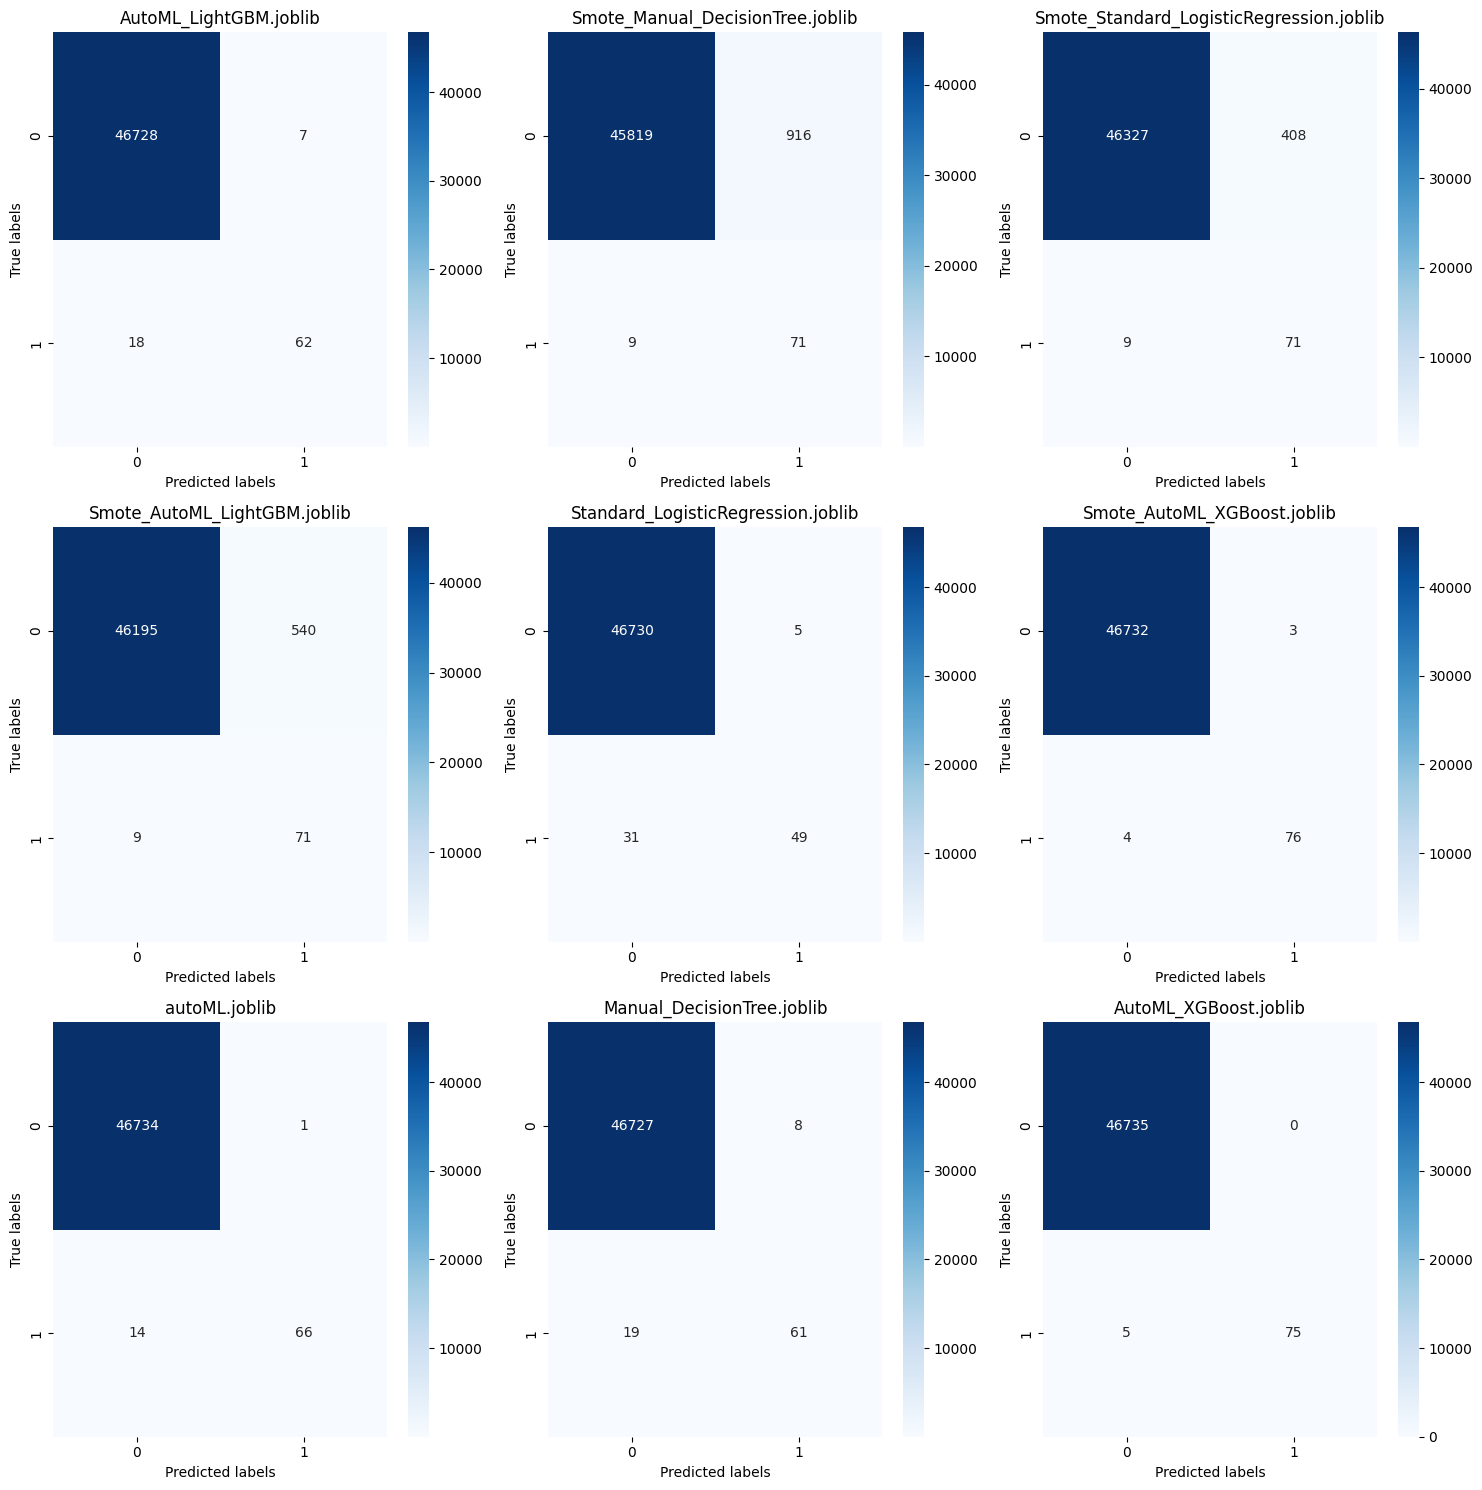

In [ ]:
# Plotting
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, model_path in enumerate(model_paths):
    model = load(model_path)
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(model_path.split('/')[-1])
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

plt.tight_layout()
plt.show()